In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.special as spec
import scipy.integrate as integrate
import scipy.optimize as opt

In [2]:
def brightDistrobution(Rb, Rd, tb):
    x = (Rb+Rd)*tb
    return x

def darkDistrobution(Rd, tb):
    x = Rd*tb
    return x

def Bo(N, Bmean):
    X = (np.power(Bmean,N)) * (np.exp(-1*Bmean)) / spec.factorial(N)
    return X

def Do(N, Dmean,Rb,Rd,tb,tau):
    X = (np.exp(-1*tb/tau)*(np.power(Dmean,N))*(np.exp(-1*Dmean)) / spec.factorial(N)) + Xo(N,Rb,Rd,tb,tau)
    return X

def Xo(N,RB,RD,tb,tau):
    X0 = []
    for n in N:
        X0 = np.append(X0, (integrate.quad(X_integrand, RD*tb, (RB+RD)*tb, args=(n,RB,RD,tau,tb)))[0])
    return X0

def X_integrand(l,n,RB,RD,tau,tb):
    return (1/(RB*tau))*np.exp((l-((RD+RB)*tb))/(RB*tau))*np.power(l,n)*np.exp(-1*l)/spec.factorial(n)

def errorD(Rb,Rd,tb,N,tau): 
    return np.sum(((np.power(Rd*tb,N)) * (np.exp(-1*(Rd*tb))) / spec.factorial(N)) + Xo(N,Rb,Rd,tb,tau))

def errorB(Rb,Rd,tb,NB):
    return np.sum((np.power((Rb+Rd)*tb,NB)) * (np.exp(-1*((Rb+Rd)*tb))) / spec.factorial(NB))

In [3]:
#Variables
nMax = 30 #Max number of detection counts we want to consider
Rb = 55800 #Bright state fluoresence rate in s^-1
Rd = 442 #Dark state fluoresence rate in s^-1
tbMax = .001 #Max bin time in s
tau = 1.167 #tau decay time for Ca40 in s 
nStep = 1 #n Granularity
tStep = .000005 #time granularity in s

In [4]:
#For each potential bin time, the ideal n cutoff between a dark and bright detection is determined

N = np.arange(start=0,stop=nMax,step=nStep)
#Bin times
BT = np.arange(start=0,stop=tbMax,step=tStep)

darkE = np.empty(0)
brightE = np.empty(0)

for tb in BT:
    Bmean = brightDistrobution(Rb,Rd,tb)
    BM = np.full(np.int_(nMax/nStep),Bmean)
    Dmean = darkDistrobution(Rd,tb)
    DM = np.full(np.int_(nMax/nStep),Dmean)

    #n counts in tb from bright
    B0 = Bo(N,BM)
    #n counts in tb from dark
    D0 = Do(N,DM,Rb,Rd,tb,tau)

    #print(np.sum(B0))

    #determine count threshold
    nc = 0
    lastDiff = np.abs(B0[0]-D0[0])
    for i, item in enumerate(B0):
        diff = (B0[i]-D0[i])
        nc = i
        if((diff>lastDiff) and diff>0):
            break
        lastDiff = diff
    nc=nc*nStep
    NB = N[np.where(N<=nc)]
    ND = N[np.where(N>=nc)]

    brightE = np.append(brightE, errorB(Rb,Rd,tb,NB))
    darkE = np.append(darkE, errorD(Rb,Rd,tb,ND,tau))

#print(np.sum(brightE))
#print(np.sum(darkE))
#brightE = brightE/np.sum(brightE)  
#darkE = darkE/np.sum(darkE)  

Text(0.5, 1.0, 'Dark and Bright Errors without Decay w/ Optimal nc')

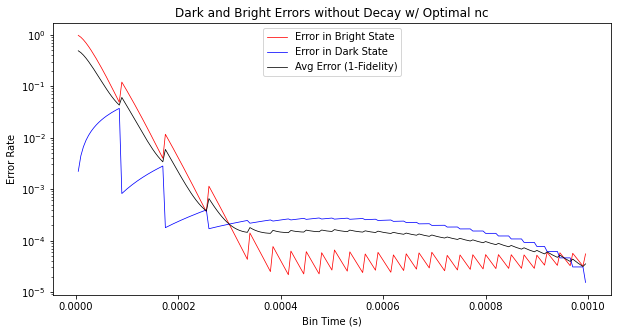

In [5]:
avgE =  (darkE+brightE)/2

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(BT[1:], brightE[1:], lw=0.75, c="r", label = "Error in Bright State")
ax1.plot(BT[1:], darkE[1:], lw=0.75, c="b", label = "Error in Dark State")
ax1.plot(BT[1:], avgE[1:], lw=0.75, c="black", label = "Avg Error (1-Fidelity)")
ax1.set_ylabel("Error Rate")
ax1.set_xlabel("Bin Time (s)")
ax1.legend(loc = 'upper center')
plt.yscale('log')
plt.title("Dark and Bright Errors without Decay w/ Optimal nc")